In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
# from sklearn.preprocessing import MinMaxScaler
import os

2024-07-19 11:47:43.814770: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-19 11:47:44.280610: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'

In [3]:
num_epochs = 150
batch_size = 2048
learning_rate = 0.001

In [4]:
AS_dataset = pd.read_csv('./Dualbad_Coupler_40000_10_60.csv', encoding='utf-8').sample(frac=1).reset_index(drop=True)
full_X = AS_dataset.loc[:,'freq':'L2'].to_numpy(dtype = np.float32)
full_y = AS_dataset.loc[:,'S11r':'S41i'].to_numpy(dtype = np.float32)
dataset_train = tf.data.Dataset.from_tensor_slices((full_X, full_y))
# dataset_train = dataset_train.shuffle(buffer_size=full_X.shape[0])
dataset_train = dataset_train.batch(batch_size)
dataset_train = dataset_train.prefetch(tf.data.experimental.AUTOTUNE)

2024-07-19 11:47:57.440696: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9604 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:17:00.0, compute capability: 7.5
2024-07-19 11:47:57.441216: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9621 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:65:00.0, compute capability: 7.5


In [5]:
class MLP(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.dense1 = tf.keras.layers.Dense(units=128, activation=tf.nn.leaky_relu)
        self.dense2 = tf.keras.layers.Dense(units=1024, activation=tf.nn.leaky_relu)
        self.dense3 = tf.keras.layers.Dense(units=128, activation=tf.nn.leaky_relu)
        self.dense4 = tf.keras.layers.Dense(units=1024, activation=tf.nn.leaky_relu)
        self.dense5 = tf.keras.layers.Dense(units=8)
    
#     @tf.function
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        output = self.dense5(x)
        return output

In [6]:
model = MLP()
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
# X_vali, y_vali = data_loader.get_batch(mode='validate')
GT_struct = tf.constant([1.63247, 1.84619, 2.01675, 1.66595, 14.7001, 13.5447, 14.653, 11.2898])
GT_X = tf.concat([tf.constant([[2.0], [2.1], [2.2], [2.3], [2.4], [5.0], [5.1], [5.2], [5.3], [5.4]]), tf.repeat([GT_struct], 10, axis=0)], axis=1)
GT_S = tf.constant([[0.12,0.394,-0.196,-0.27,-0.733,-0.071,-0.179,-0.36],
[0.191,0.22,-0.21,-0.21,-0.764,0.16,-0.24,-0.374],
[0.163,0.008,-0.185,-0.16,-0.681,0.422,-0.344,-0.362],
[0.021,-0.164,-0.144,-0.163,-0.464,0.629,-0.46,-0.278],
[-0.179,-0.235,-0.156,-0.211,-0.175,0.706,-0.521,-0.13],
[0.256,-0.007,-0.353,-3.56E-04,-0.277,0.716,-0.385,0.208],
[0.124,-0.087,-0.287,0.058,-0.055,0.814,-0.381,0.221],
[-0.043,-0.082,-0.205,0.054,0.198,0.805,-0.394,0.271],
[-0.176,0.006,-0.164,-0.005,0.407,0.692,-0.377,0.356],
[-0.242,0.131,-0.186,-0.065,0.533,0.536,-0.315,0.434]])

2023-09-19 10:11:54.555198: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x564b2c997730 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-19 10:11:54.555217: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-09-19 10:11:54.555221: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-09-19 10:11:54.558595: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-19 10:11:54.661321: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-09-19 10:11:54.783586: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


epoch:0
train mse:0.050538208335638046 rmse:0.2248070389032364 mae:0.17314030230045319 r2:0.5864115357398987 EC:0.5437366962432861
GT mse:0.1126699298620224 rmse:0.33566340804100037 mae:0.2688261866569519 r2:0.0652155876159668
epoch:10
train mse:0.009324164129793644 rmse:0.09656170755624771 mae:0.06924700736999512 r2:0.9236940145492554 EC:0.8909760117530823
GT mse:0.009892009198665619 rmse:0.09945857524871826 mae:0.07221753150224686 r2:0.9179293513298035
epoch:20
train mse:0.0050539541989564896 rmse:0.0710911676287651 mae:0.05172726884484291 r2:0.9586400389671326 EC:0.9301701188087463
GT mse:0.009512047283351421 rmse:0.09752972424030304 mae:0.07143811881542206 r2:0.9210817813873291
epoch:30
train mse:0.003472505835816264 rmse:0.05892797186970711 mae:0.04209411144256592 r2:0.9715821146965027 EC:0.9483223557472229
GT mse:0.0046072849072515965 rmse:0.06787697970867157 mae:0.04930286481976509 r2:0.9617748856544495
epoch:40
train mse:0.003322191769257188 rmse:0.05763845890760422 mae:0.04164

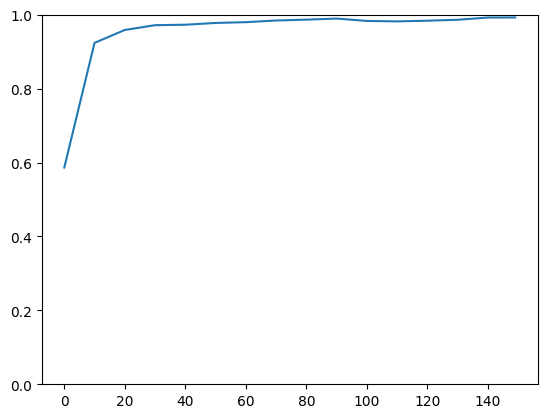

In [6]:
showX = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 149]
showY1 = []
showY2 = []
for epoch_index in range(num_epochs):
    for X, y in dataset_train:
        with tf.GradientTape() as tape:
            y_pred = model(X)
            tr_mse = tf.reduce_mean(tf.square(y_pred - y))
        grads = tape.gradient(tr_mse, model.variables)
        optimizer.apply_gradients(grads_and_vars=zip(grads, model.variables))
    if epoch_index % 10 == 0 or epoch_index == num_epochs - 1:
        tr_EC = tf.reduce_mean(tf.reduce_sum(tf.square(y_pred), axis=1))
        tr_rmse = tf.sqrt(tr_mse)
        tr_mae = tf.reduce_mean(tf.abs(y_pred - y))
        tr_r2 = 1 - tf.reduce_sum(tf.square(y_pred - y)) / tf.reduce_sum(tf.square(y - tf.reduce_mean(y)))
        print("epoch:{}".format(epoch_index))
        print("train mse:{} rmse:{} mae:{} r2:{} EC:{}".format(tr_mse, tr_rmse, tr_mae, tr_r2, tr_EC))
        # y_v_p = model(X_vali[:,1:], X_vali[:,:1])
        # va_mse = tf.reduce_mean(tf.square(y_v_p - y_vali))
        # va_rmse = tf.sqrt(va_mse)
        # va_mae = tf.reduce_mean(tf.abs(y_v_p - y_vali))
        # va_r2 = 1 - tf.reduce_sum(tf.square(y_v_p - y_vali)) / tf.reduce_sum(tf.square(y_vali - tf.reduce_mean(y_vali)))
        # print("vali mse:{} rmse:{} mae:{} r2:{}".format(va_mse, va_rmse, va_mae, va_r2))
        GT_y = model(GT_X)
        # GT_loss = loss_func(GT_y[0:1], GT_y[1:2], GT_y[2:3], GT_y[3:4], GT_y[4:5], GT_y[5:6]) + loss_func(GT_y[6:7], GT_y[7:8], GT_y[8:9], GT_y[9:10], GT_y[10:11], GT_y[11:12])
        GT_mse = tf.reduce_mean(tf.square(GT_y - GT_S))
        GT_rmse = tf.sqrt(GT_mse)
        GT_mae = tf.reduce_mean(tf.abs(GT_y - GT_S))
        GT_r2 = 1 - tf.reduce_sum(tf.square(GT_y - GT_S)) / tf.reduce_sum(tf.square(GT_S - tf.reduce_mean(GT_S)))
        print("GT mse:{} rmse:{} mae:{} r2:{}".format(GT_mse, GT_rmse, GT_mae, GT_r2))
        showY1.append(tr_r2)
        # showY2.append(va_r2)
plt.plot(showX, showY1)
# plt.plot(showX, showY2)
plt.ylim(0, 1)
plt.show()

In [7]:
tf.saved_model.save(model, './models')

INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


In [5]:
model = tf.saved_model.load('./models')

In [6]:
def dgn_obj(s_para, dis = False):
    E = tf.square(s_para)
    E31 = E[:,4] + E[:,5]
    E41 = E[:,6] + E[:,7]
    mag31 = tf.sqrt(E31)
    mag41 = tf.sqrt(E41)
    # l1 = tf.square(E31 - 0.7)
    # l2 = tf.square(E41 - 0.3)
    # l1 = tf.square(E31 - 0.681)
    # l2 = tf.square(E41 - 0.285)
    l1 = tf.abs(mag31 - 0.837)
    l2 = tf.abs(mag41 - 0.548)
    if dis == True:
        print(mag31.numpy())
        print(mag41.numpy())
        print("l1", l1.numpy()[0])
        print("l2", l2.numpy()[0])
    return l1 + l2
def loss_func(s1, s2, s3, s4, s5, dis = False):
    var = tf.reduce_sum(tf.nn.moments(tf.stack([s1, s2, s3, s4, s5], axis=1), [1])[1][:, 4: 8], axis=-1)
    if dis == True:
        print("var", var.numpy()[0])
    return dgn_obj(s1, dis) + dgn_obj(s2, dis) + dgn_obj(s3, dis) + dgn_obj(s4, dis) + dgn_obj(s5, dis)

In [56]:
# def dgn_obj(s_para, dis = False):
#     E = tf.square(s_para)
#     E11 = E[:,0] + E[:,1]
#     E21 = E[:,2] + E[:,3]
#     E31 = E[:,4] + E[:,5]
#     E41 = E[:,6] + E[:,7]
#     l1 = E11 + E21 - E31 - E41
#     l2 = tf.abs(E31 / (E31 + E41) - 0.7)
#     # l3 = tf.abs(tf.math.atan2(s_para[:,3], s_para[:,2]) - tf.math.atan2(s_para[:,5], s_para[:,4]) - np.pi / 4)
#     l4 = tf.abs(tf.reduce_sum(E, axis=1) - 1)
#     loss = l1 * 0.6 + l2 * 1.4 + l4
#     if dis == True:
#         print("l1", l1.numpy()[0], "W l1", l1.numpy()[0] * 0.5)
#         print("l2", l2.numpy()[0],  "W l2", l4.numpy()[0] * 1.5)
#         # print("l3", l3.numpy()[0])
#         print("l4", l4.numpy()[0],  "W l4", l4.numpy()[0])
#     return loss
# def loss_func(s1, s2, s3, s4, s5, dis = False):
#     # 31和41的方差
#     var = tf.reduce_sum(tf.nn.moments(tf.stack([s1, s2, s3, s4, s5], axis=1), [1])[1][:, 4: 8], axis=-1)
#     if dis == True:
#         print("var", var.numpy()[0],  "W var", var.numpy()[0] * 1.5)
#     return var * 2 + dgn_obj(s1, dis) + dgn_obj(s2, dis) + dgn_obj(s3, dis) + dgn_obj(s4, dis) + dgn_obj(s5, dis)

In [13]:
num_nodes = 10000
num_node_epochs = 1000

In [14]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)

mmin = np.min(full_X[: , 1: ], axis=0)
mmax = np.max(full_X[: , 1: ], axis=0)

# structure.append(tf.Variable(np.random.uniform(0, 1, (num_nodes, 10)), dtype=tf.float32))
structure = tf.Variable(np.random.uniform(mmin, mmax, (num_nodes, 8)), dtype=tf.float32)

freq20 = tf.ones([num_nodes, 1]) * 2.0
freq21 = tf.ones([num_nodes, 1]) * 2.1
freq22 = tf.ones([num_nodes, 1]) * 2.2
freq23 = tf.ones([num_nodes, 1]) * 2.3
freq24 = tf.ones([num_nodes, 1]) * 2.4

freq50 = tf.ones([num_nodes, 1]) * 5.0
freq51 = tf.ones([num_nodes, 1]) * 5.1
freq52 = tf.ones([num_nodes, 1]) * 5.2
freq53 = tf.ones([num_nodes, 1]) * 5.3
freq54 = tf.ones([num_nodes, 1]) * 5.4

In [15]:
bestLoss = 1000
bestStructure = 0

In [16]:
def check(structure):
    inva_place1 = tf.where(tf.logical_or(structure[:,:4] < 1, structure[:,:4] > 5))
    structure = tf.tensor_scatter_nd_update(structure, [inva_place1], [np.random.uniform(mmin[inva_place1[:,1]], mmax[inva_place1[:,1]], (inva_place1.shape[0]))])
    
    inva_place2 = tf.where(tf.logical_or(structure[:,4:6] < 2, structure[:,4:6] > 22)) + [0, 4]
    structure = tf.tensor_scatter_nd_update(structure, [inva_place2], [np.random.uniform(mmin[inva_place2[:,1]], mmax[inva_place2[:,1]], (inva_place2.shape[0]))])
    
    inva_place3 = tf.where(tf.logical_or(structure[:,6:8] < 4, structure[:,6:8] > 44)) + [0, 6]
    structure = tf.tensor_scatter_nd_update(structure, [inva_place3], [np.random.uniform(mmin[inva_place3[:,1]], mmax[inva_place3[:,1]], (inva_place3.shape[0]))])
    
    return tf.Variable(structure)
    
    # structure[j] = tf.Variable(tf.tensor_scatter_nd_update(structure[j], [nega_place], [np.random.uniform(0, 1, (nega_place.shape[0]))]))

In [17]:
import time
t0 = time.time()
for i in range(num_node_epochs):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(structure)
        y_pred20 = model(tf.concat([freq20, structure], axis = 1))
        y_pred21 = model(tf.concat([freq21, structure], axis = 1))
        y_pred22 = model(tf.concat([freq22, structure], axis = 1))
        y_pred23 = model(tf.concat([freq23, structure], axis = 1))
        y_pred24 = model(tf.concat([freq24, structure], axis = 1))
        
        y_pred50 = model(tf.concat([freq50, structure], axis = 1))
        y_pred51 = model(tf.concat([freq51, structure], axis = 1))
        y_pred52 = model(tf.concat([freq52, structure], axis = 1))
        y_pred53 = model(tf.concat([freq53, structure], axis = 1))
        y_pred54 = model(tf.concat([freq54, structure], axis = 1))
        
        loss = loss_func(y_pred20, y_pred21, y_pred22, y_pred23, y_pred24) + loss_func(y_pred50, y_pred51, y_pred52, y_pred53, y_pred54)
    minLoss = tf.reduce_min(loss).numpy()
    minIndex = tf.argmin(loss).numpy()
    minS = structure[minIndex].numpy()
    grads = tape.gradient(loss, structure)
    opt.apply_gradients(grads_and_vars=zip([grads], [structure]))
    structure = check(structure)
    if minLoss < bestLoss:
        bestLoss = minLoss
        bestStructure = minS
        # bestStructure = data_loader.mmX.inverse_transform([minS[0]])[0]
        print(minIndex)
        print(i, bestLoss)
        print(" ".join(map(str, bestStructure)))
        print(time.time() - t0)
        print()

9443
0 2.2804193
1.2532985 3.347382 3.89753 2.985285 14.048407 4.7526827 25.226765 15.456003
0.07154655456542969

9443
1 2.2473965
1.2432983 3.357382 3.9075303 2.9752848 14.038406 4.7626824 25.216764 15.446003
0.1512467861175537

9443
2 2.2276046
1.2358569 3.364823 3.9149718 2.9678433 14.030965 4.7701235 25.209324 15.438561
0.21768689155578613

2620
3 2.2057729
1.6356817 1.6660215 1.6191992 2.6152852 6.386911 5.218387 6.993915 27.702469
0.2909107208251953

2620
4 2.1840432
1.6298705 1.6602103 1.6133878 2.6210964 6.3810997 5.212576 6.9997263 27.696657
0.3644094467163086

2620
5 2.1646721
1.6244156 1.6547555 1.6079329 2.6265512 6.3756447 5.207121 7.0051813 27.691202
0.43242454528808594

2620
6 2.1468918
1.6191945 1.6495345 1.6027118 2.6317723 6.3704233 5.2019 7.0104027 27.685982
0.5021200180053711

2620
7 2.136977
1.6141307 1.654598 1.597648 2.6267085 6.36536 5.1968365 7.015466 27.680918
0.574207067489624

2620
8 2.1274161
1.6091733 1.6595551 1.5926905 2.621751 6.360402 5.1918793 7.02042

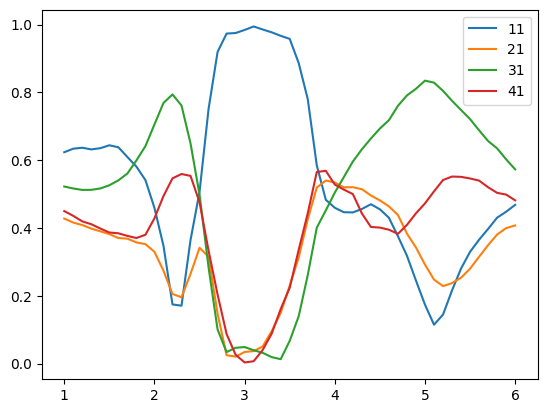

In [18]:
fig_freq = tf.linspace(1.0, 6.0, 51)
fig_x = tf.concat([tf.reshape(fig_freq, (-1, 1)), tf.tile([bestStructure], [51, 1])], axis=-1)
fig_y = model(fig_x)
E = tf.square(fig_y)
M11 = tf.sqrt(E[:,0] + E[:,1])
M21 = tf.sqrt(E[:,2] + E[:,3])
M31 = tf.sqrt(E[:,4] + E[:,5])
M41 = tf.sqrt(E[:,6] + E[:,7])
plt.figure()
plt.plot(fig_freq, M11, label='11')
plt.plot(fig_freq, M21, label='21')
plt.plot(fig_freq, M31, label='31')
plt.plot(fig_freq, M41, label='41')
plt.legend()
plt.show()

In [15]:
# S4P
l = fig_y.numpy().tolist()
for i in range(len(l)):
    print(round(fig_freq.numpy()[i], 1), end="\t")
    print(l[i][0], l[i][1], "0\t" * 6, sep="\t")
    print(l[i][2], l[i][3], "0\t" * 6, sep="\t")
    print(l[i][4], l[i][5], "0\t" * 6, sep="\t")
    print(l[i][6], l[i][7], "0\t" * 6, sep="\t")

1.0	-0.5885058045387268	0.2386728674173355	0	0	0	0	0	0	
0.21804800629615784	-0.361627459526062	0	0	0	0	0	0	
0.15833503007888794	-0.4961269497871399	0	0	0	0	0	0	
0.21457625925540924	-0.38050583004951477	0	0	0	0	0	0	
1.1	-0.5743961334228516	0.2890695333480835	0	0	0	0	0	0	
0.17701229453086853	-0.3721081018447876	0	0	0	0	0	0	
0.09553606063127518	-0.5082343220710754	0	0	0	0	0	0	
0.17940576374530792	-0.38310280442237854	0	0	0	0	0	0	
1.2	-0.5428518652915955	0.33797991275787354	0	0	0	0	0	0	
0.13320747017860413	-0.3823961019515991	0	0	0	0	0	0	
0.024328656494617462	-0.513569176197052	0	0	0	0	0	0	
0.13303954899311066	-0.3884328305721283	0	0	0	0	0	0	
1.3	-0.507034182548523	0.3852449655532837	0	0	0	0	0	0	
0.08932486921548843	-0.3860691785812378	0	0	0	0	0	0	
-0.0473937913775444	-0.5135489106178284	0	0	0	0	0	0	
0.09503044188022614	-0.39469674229621887	0	0	0	0	0	0	
1.4	-0.46685591340065	0.43895769119262695	0	0	0	0	0	0	
0.0426204577088356	-0.38518112897872925	0	0	0	0	0	0	
-0.12202393263578415	-0.507840

In [16]:
MP_y = model(tf.concat([tf.constant([[2.0], [2.1], [2.2], [2.3], [2.4], [5.0], [5.1], [5.2], [5.3], [5.4]]), tf.repeat([bestStructure], 10, axis=0)], axis=1))
GT_y = model(GT_X)

print("MP")
MP_loss = loss_func(MP_y[0:1], MP_y[1:2], MP_y[2:3], MP_y[3:4], MP_y[4:5], dis = True) + loss_func(MP_y[5:6], MP_y[6:7], MP_y[7:8], MP_y[8:9], MP_y[9:10], dis = True)
print(MP_loss)

print("GT")
GT_loss = loss_func(GT_y[0:1], GT_y[1:2], GT_y[2:3], GT_y[3:4], GT_y[4:5], dis = True) + loss_func(GT_y[5:6], GT_y[6:7], GT_y[7:8], GT_y[8:9], GT_y[9:10], dis = True)
print(GT_loss)

MP
var 0.17962962
[0.7138875]
[0.42662916]
l1 0.1231125
l2 0.12137082
[0.76633334]
[0.49594265]
l1 0.07066667
l2 0.052057326
[0.78678256]
[0.5462792]
l1 0.05021745
l2 0.0017207861
[0.76319534]
[0.56334895]
l1 0.07380468
l2 0.015348971
[0.7105412]
[0.5511837]
l1 0.12645882
l2 0.0031837225
var 0.070996426
[0.8102917]
[0.47654325]
l1 0.026708305
l2 0.07145673
[0.83166075]
[0.50283664]
l1 0.005339265
l2 0.045163333
[0.8072292]
[0.52833706]
l1 0.029770792
l2 0.019662917
[0.7713655]
[0.5454029]
l1 0.06563449
l2 0.0025970936
[0.73100287]
[0.54727614]
l1 0.105997145
l2 0.0007238388
tf.Tensor([1.0109956], shape=(1,), dtype=float32)
GT
var 0.16339658
[0.7364826]
[0.39517248]
l1 0.10051739
l2 0.1528275
[0.7916956]
[0.44117257]
l1 0.045304418
l2 0.10682741
[0.8101463]
[0.50185007]
l1 0.02685374
l2 0.04614991
[0.78345656]
[0.51465935]
l1 0.05354345
l2 0.033340633
[0.73950064]
[0.521482]
l1 0.09749937
l2 0.026517987
var 0.09603846
[0.78325546]
[0.41100135]
l1 0.053744555
l2 0.13699862
[0.8276357]
[0

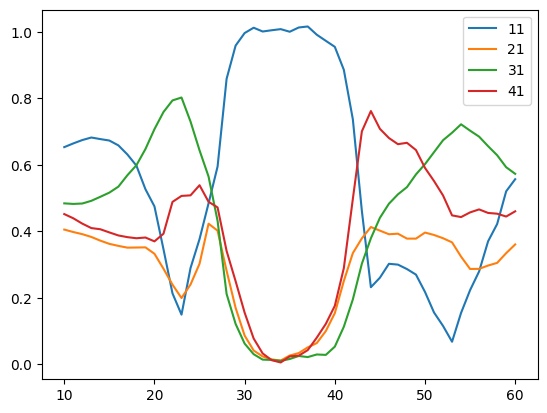

In [15]:
fig_freq = tf.linspace(10., 60, 51)
fig_x = tf.concat([tf.reshape(fig_freq, (-1, 1)), tf.tile([GT_struct], [51, 1])], axis=-1)
fig_y = model(fig_x[:,1:], fig_x[:,:1])
E = tf.square(fig_y)
M11 = tf.sqrt(E[:,0] + E[:,1])
M21 = tf.sqrt(E[:,2] + E[:,3])
M31 = tf.sqrt(E[:,4] + E[:,5])
M41 = tf.sqrt(E[:,6] + E[:,7])
plt.figure()
plt.plot(fig_freq, M11, label='11')
plt.plot(fig_freq, M21, label='21')
plt.plot(fig_freq, M31, label='31')
plt.plot(fig_freq, M41, label='41')
plt.legend()
plt.show()